# **SMART GARDENING**

* Dataset : https://drive.google.com/file/d/1AdEpih8L3tNphGICseptlfltunaWPb2R/view?usp=sharing
* 6789 images, from Bing search engine. (80% training, 10% validation, 10% test)
* 7 classes : aglonema (0), janda_bolong(1), kuping_gajah(2), lidah_mertua(3), sirih_gading(4), tanaman_lipstik_gantung(5), tanaman_suplir(6). 

* Data augmentation : randomFlip, randomRotation
* Transfer learning MobileNetV2 - Fine tuning 
* Training Accuracy : 93, Validation Accuracy : 91, Testing Accuracy : 93


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

from re import sub

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
path_zip = '/content/drive/MyDrive/capstone project/plant_dataset_JPEG_NEW.zip'

zipref = zipfile.ZipFile(path_zip, 'r')

zipref.extractall('/content')
zipref.close()

In [5]:
PATH = "/content/plant_dataset_JPEG_NEW"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5499 files belonging to 7 classes.


In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  label_mode = 'categorical',
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1290 files belonging to 7 classes.


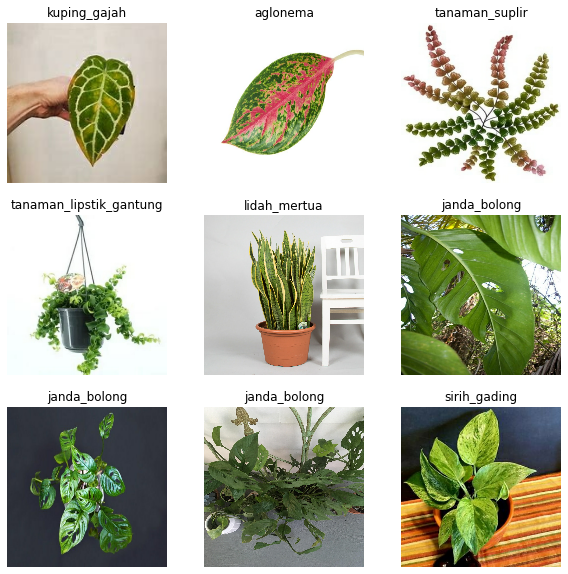

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
    plt.title(title)
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 65
Number of test batches: 64


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

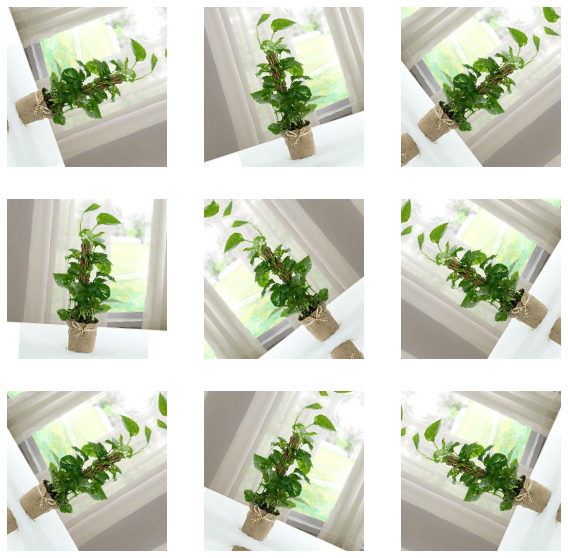

In [43]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 1280)


In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 7)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
outputs.shape

TensorShape([None, 7])

In [23]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

65/65 [==============================] - 18s 186ms/step - loss: 2.2787 - accuracy: 0.2000


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.28
initial accuracy: 0.20


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
550/550 [==============================] - 136s 242ms/step - loss: 0.8869 - accuracy: 0.6921 - val_loss: 0.6383 - val_accuracy: 0.7877
Epoch 2/10
550/550 [==============================] - 134s 242ms/step - loss: 0.5759 - accuracy: 0.8003 - val_loss: 0.6096 - val_accuracy: 0.8046
Epoch 3/10
550/550 [==============================] - 133s 240ms/step - loss: 0.5306 - accuracy: 0.8209 - val_loss: 0.5538 - val_accuracy: 0.8231
Epoch 4/10
550/550 [==============================] - 135s 245ms/step - loss: 0.4830 - accuracy: 0.8342 - val_loss: 0.5867 - val_accuracy: 0.8215
Epoch 5/10
550/550 [==============================] - 134s 243ms/step - loss: 0.4641 - accuracy: 0.8423 - val_loss: 0.5948 - val_accuracy: 0.8062
Epoch 6/10
550/550 [==============================] - 136s 246ms/step - loss: 0.4496 - accuracy: 0.8469 - val_loss: 0.6087 - val_accuracy: 0.8215
Epoch 7/10
550/550 [==============================] - 132s 239ms/step - loss: 0.4357 - accuracy: 0.8503 - val_loss: 0.5652 -

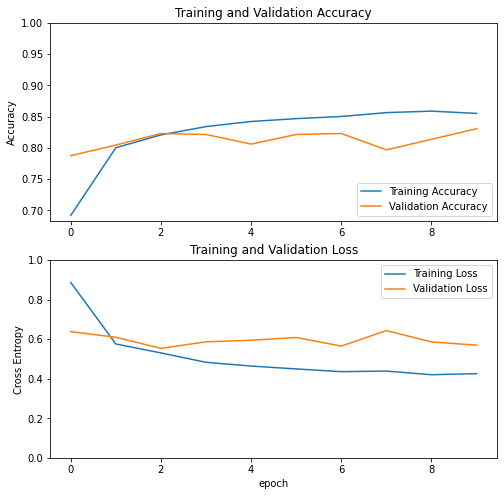

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **FINE TUNING**

In [30]:
base_model.trainable = True

In [31]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [32]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [34]:
len(model.trainable_variables)

56

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
550/550 [==============================] - 216s 385ms/step - loss: 0.6585 - accuracy: 0.7769 - val_loss: 0.3568 - val_accuracy: 0.8662
Epoch 11/20
550/550 [==============================] - 214s 388ms/step - loss: 0.4703 - accuracy: 0.8458 - val_loss: 0.6195 - val_accuracy: 0.8015
Epoch 12/20
550/550 [==============================] - 213s 386ms/step - loss: 0.3678 - accuracy: 0.8778 - val_loss: 0.4283 - val_accuracy: 0.8446
Epoch 13/20
550/550 [==============================] - 214s 389ms/step - loss: 0.3252 - accuracy: 0.8902 - val_loss: 0.3216 - val_accuracy: 0.9000
Epoch 14/20
550/550 [==============================] - 216s 391ms/step - loss: 0.2931 - accuracy: 0.9054 - val_loss: 0.3381 - val_accuracy: 0.8877
Epoch 15/20
550/550 [==============================] - 217s 394ms/step - loss: 0.2588 - accuracy: 0.9138 - val_loss: 0.3517 - val_accuracy: 0.9046
Epoch 16/20
550/550 [==============================] - 218s 396ms/step - loss: 0.2305 - accuracy: 0.9229 - val_loss: 0

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

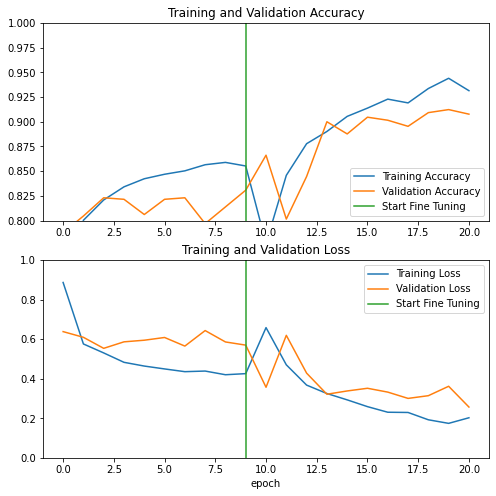

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

64/64 [==============================] - 13s 198ms/step - loss: 0.2520 - accuracy: 0.9266
Test accuracy : 0.926562488079071


Predictions:
 [1, 4, 6, 5, 5, 3, 3, 0, 2, 2]
Labels:
 [1, 4, 6, 5, 5, 3, 1, 0, 2, 2]


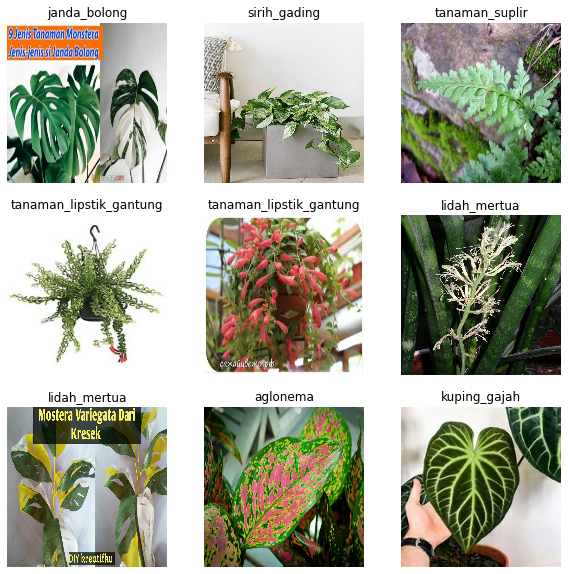

In [50]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [41]:
# model.save('/content/5_model_TLFT_akurasi_93_91_93.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
